## Objective

Make a simple Random Forests model to determine what factors affect the number of 311 issues.

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.dirname('.'), "../preprocessing"))

In [2]:
from transform_for_num_issues_pred import main as transform_dataset

In [33]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")

from helper_functions import dummify_cols_and_baselines, make_alphas

In [4]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

In [5]:
df_transformed = transform_dataset(df_orig)
df_transformed.shape

../preprocessing/transform_for_num_issues_pred.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_subset['NUM_ISSUES'] = 1


(822, 27)

## Choosing columns

In [6]:
cols_orig_dataset = ['NUM_ISSUES', 'tract_and_block_group']
cols_census = ['race_white',
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_food_stamps',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'bedroom_std_dev',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']

In [7]:
df_col_subset = df_transformed[cols_orig_dataset + cols_census]
df_col_subset.shape

(822, 24)

In [8]:
df = df_col_subset.dropna().drop_duplicates()
df.shape

(558, 24)

## Removing outliers

0303003 is City Hall, which is where issues are assigned to when they don't have a location. Ideally, I would find out which issues truly took place in that block group and filter accordingly.

The other Census block groups I chose from looking at a Tableau cloropleth map. They are places with few, if any people living there, like parks and in the financial distinct.

In [9]:
outliers = ('9818001', '9811003', '9807001', '0303003', '0701018')

In [10]:
df = df[~df.tract_and_block_group.isin(outliers)].drop('tract_and_block_group', axis=1)
df.shape

(553, 23)

In [11]:
df_transformed.NUM_ISSUES.describe()

count      822.000000
mean      1952.018248
std       5419.910281
min         50.000000
25%        582.250000
50%        833.000000
75%       1219.000000
max      29667.000000
Name: NUM_ISSUES, dtype: float64

In [12]:
df.NUM_ISSUES.describe()

count     553.000000
mean      874.059675
std       461.379271
min        50.000000
25%       580.000000
50%       807.000000
75%      1101.000000
max      3007.000000
Name: NUM_ISSUES, dtype: float64

## Dummify

In [13]:
cols_to_dummify = df.dtypes[df.dtypes == object].index
cols_to_dummify

Index([u'school', u'housing'], dtype='object')

In [14]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df, cols_to_dummify)

8_6th_grade is baseline 0 2
rent is baseline 1 2


In [15]:
df_dummified.shape

(553, 32)

## Running model

In [16]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer


/Users/datascientist/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop('NUM_ISSUES', axis=1), 
    df_dummified.NUM_ISSUES, 
    test_size=0.2
)

In [18]:
pipe = make_pipeline(RandomForestRegressor())

In [ ]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

In [19]:
params = {'randomforestregressor__max_depth': [160, 200, 230], 
          'randomforestregressor__n_estimators': [10, 30],
          'randomforestregressor__max_features': [0.95]
         }
# params = {'randomforestregressor__max_depth': [5, 8, 10], 
#           'randomforestregressor__n_estimators': [100]} # best one
model = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5)
model.fit(X_train, y_train)
results = pd.DataFrame(model.cv_results_).T

In [20]:
model.best_score_

0.39449172037729957

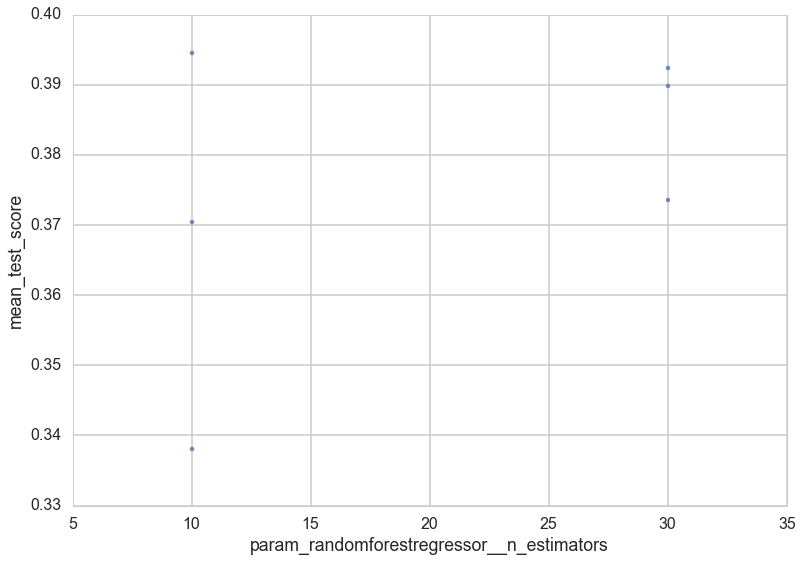

In [34]:
sns.regplot(
    x='param_randomforestregressor__n_estimators',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__n_estimators', 'mean_test_score']], 
    fit_reg=False
);

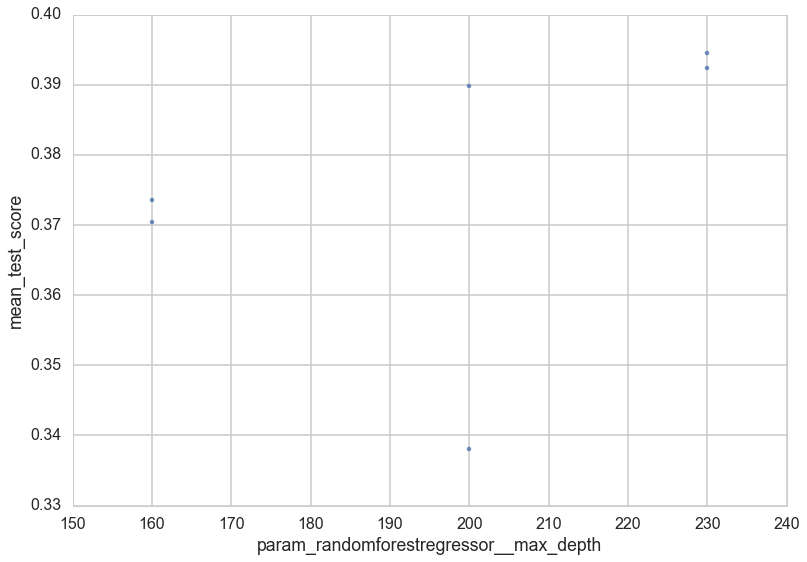

In [35]:
sns.regplot(
    x='param_randomforestregressor__max_depth',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__max_depth', 'mean_test_score']], 
    fit_reg=False
);

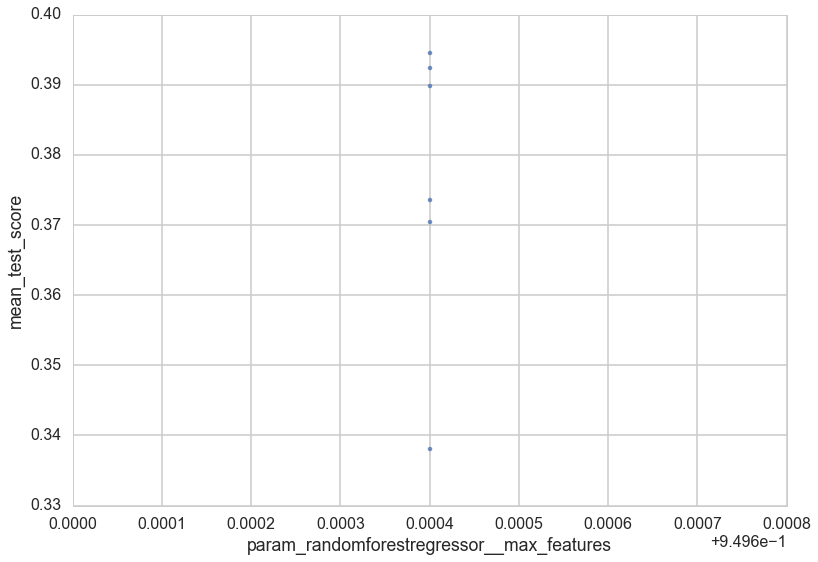

In [36]:
sns.regplot(
    x='param_randomforestregressor__max_features',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__max_features', 'mean_test_score']], 
    fit_reg=False
);

In [26]:
results.head(6)

,0,1,2,3,4,5
mean_fit_time,0.153448,0.366037,0.120166,0.356429,0.115375,0.306697
mean_score_time,0.0144906,0.0440918,0.0129309,0.0365126,0.0122641,0.0292189
mean_test_score,0.370416,0.373561,0.33807,0.389846,0.394492,0.392383
mean_train_score,0.875425,0.905297,0.888,0.900239,0.884884,0.898678
param_randomforestregressor__max_depth,160,160,200,200,230,230
param_randomforestregressor__max_features,0.95,0.95,0.95,0.95,0.95,0.95


In [27]:
model.best_params_

{'randomforestregressor__max_depth': 230,
 'randomforestregressor__max_features': 0.95,
 'randomforestregressor__n_estimators': 10}

In [28]:
model.score(X_test, y_test)

0.23775763097259928

### Feature Importance

In [29]:
feature_importances = pd.np.argsort(model.best_estimator_.steps[0][-1].feature_importances_)
features = list(df_dummified.drop('NUM_ISSUES', axis=1).columns[feature_importances[-1:-11:-1]])
pd.DataFrame({'top ten features': features})

,top ten features
0,value_std_dev
1,school_std_dev
2,value
3,bedroom_std_dev
4,earned_income_per_capita
5,income_std_dev
6,housing_std_dev
7,race_asian
8,rent_std_dev
9,poverty_pop_below_poverty_level


## Conclusion

Random Forests' improved performance implies that the data is not very linear. We're still overfitting, but it's the best we can do without dimensionality reduction or manual feature subselection.